# Predicting Services from Unrelated Censys Data #
NOTE: In order to run this notebook, you need the following:
- captum 0.6.0
- pytorch 2.0.0 cuda 11.7
- scikit-learn 1.2.2
## Introduction ##
Machine learning has proven capable at discovering non-linear relationships between large quantities of data. When I first interacted with the Censys dataset, the idea of applying machine learning approaches to it stuck. Censys provides us with a great deal of data regarding the systems it interacts with, ranging from geographical information to ASN data to information about the software they are running to the services the system hosts. Is there a relationship between these? Specifically, is there a relationship between the services a system runs and the seemingly unrelated information such as geographical location, ASN information, and software information? If such a relationship exists, can we discover it using a machine learning approach and, using novel visualization techniques, can we unpack the black box of machine learning and learn why it made the decisions it did, which would help us understand what the relationship is?

## Related Work ##
Applying machine learning to internet data is not a novel idea: Bilge et al. (2014) utilized trained decision tree classifiers coupled with a dataset compiled from various anti-virus companies to detect malicious domains. Regarding the Censys Universal Internet Dataset specifically, Sarabi and Liu (2018) presented a means of generating a lightweight numerical embeddings of Censys data entries. Generating embeddings is a crucial first step in applying machine learning algorithms, as any data needs to be encoded in a format that they can utilize. After initial investigation into this approach, it was deemed inappropriate; Sarabi and Liu generate embeddings that are lower dimension than the Censys dataset, meaning that input feature information is abstracted away. This goes against the goals of the project, which aims to aid in human understanding of how each input affects the output. Ultimately, it was decided to generate the embeddings manually.

In recent years, an effort has been made by many to introduce interpretability and explainability to machine learning applications, as all too often these systems tend to be black boxes whose decisions cannot be explained even by their creators. To this end, Captum (Kokhlikyan et al. 2020) proves incredibly useful; it is a unified and generic library aimed at model interpretebility built for Pytorch, one of the most popular frameworks to develop machine learning applications. We use Captum's "Integrated Gradients" to explain our model's decision making.

## Approach ##
### Data Preprocessing ###
Data was taken from the April 16th weekly snapshot of the Censys Universal Internet Dataset. Following are the fields included with the data, along with the preprocessing steps taken:
- __Country__
    - __Country Code__: Compiled into a set, converted into numerical representations (e.g. [“US”, “CA”, “RU”] became [0, 1, 2]), and normalized between 0 and 1 (e.g. [0, 1, 2] became [0, 0.5, 1])
- __Coordinates__
    - __Latitude__: Normalized to fall between 0 and 1 (by dividing by the largest value) in the normalized dataset. Untouched in the unnormalized one
    - __Longitude__: Normalized to fall between 0 and 1 in the normalized dataset. Untouched in the unnormalized one
- __ASN__
    - __ASN Number__: Normalized to fall between 0 and 1 in the normalized dataset. Untouched in the unnormalized one
    - __ASN Country Code__: Same approach as country code
- __Software__
    - __Vendor__: Same approach as country code
    - __Product__: Same approach as country code
    - __Version__: Non-numerical characters were trimmed, every decimal after the first was removed (e.g. “1.14.28-eq” became “1.1428”), then normalized to fall between 0 and 1 in the normalized dataset. Untouched in the unnormalized one
- __Labels__: Labels were derived from the "service names list" field; these were converted into numerical representations and then into multihot vector of size equal to the number of services we are predicting.

Following are the excluded fields, along with the reasoning behind their exclusion:
- __Host_identifier__: Unique to every host, does not provide much information
- __Services__: The purpose of the project is to discover a relationship between the data seemingly unrelated to hosted services; including information about the services would go against this purpose and make classification too simple for the model
- __Snapshot Date__: We are working with only one weekly snapshot, so this would be the same for all
- __IPv4_int/IPv6_int__: Unique to every host, does not provide much info
- __ASN__
    - __BGP_prefix__: Covered by ASN number; difficult to encode IP in a way that’s meaningful and not actively harmful for a machine learning algorithm.
- __Location__
    - __Country__: Encoded by coordinates
    - __Region__: Encoded by coordinates
    - __City__: Encoded by coordinate
    - __Timezone__: Encoded by coordinate
    - __Registered country__: Redundant with country code
- __Ports List__: Same reason as services

### Machine Learning Algorithm ###
A three-layer perceptron was decided on due to input only being 8 features. Perceptrons are simpler than other ML approaches such as convolution, but still maintain incredibly ability to discover nonlinear relations between data. Each layer contained 100 nodes, with an additional output layer of size equal to the number of services we are predicting. An additional perceptron was initially designed that included an initial attention layer before the 3 hidden layers; attention layers learn which inputs are important and modify their outputs are accordingly. However, upon further investigation, it was found that using an attention layer did not work with the format of the input data. The code for the model is still included for future work.

### Displaying Data ###
First, let's figure out what we're working with. Let's grab the top 20 services present, as well as graph the occurences of all services on a log scale. We see that there are 89 services present in the 500k entries present in our data (run this cell twice to properly format the graph)

Top 20 services by occurence: ['HTTP', 'UNKNOWN', 'SSH', 'NTP', 'SMTP', 'FTP', 'IKE', 'POP3', 'IMAP', 'RDP', 'PPTP', 'TELNET', 'DNS', 'RTSP', 'MYSQL', 'VNC', 'OPENVPN', 'SNMP', 'NETBIOS', 'PORTMAP']


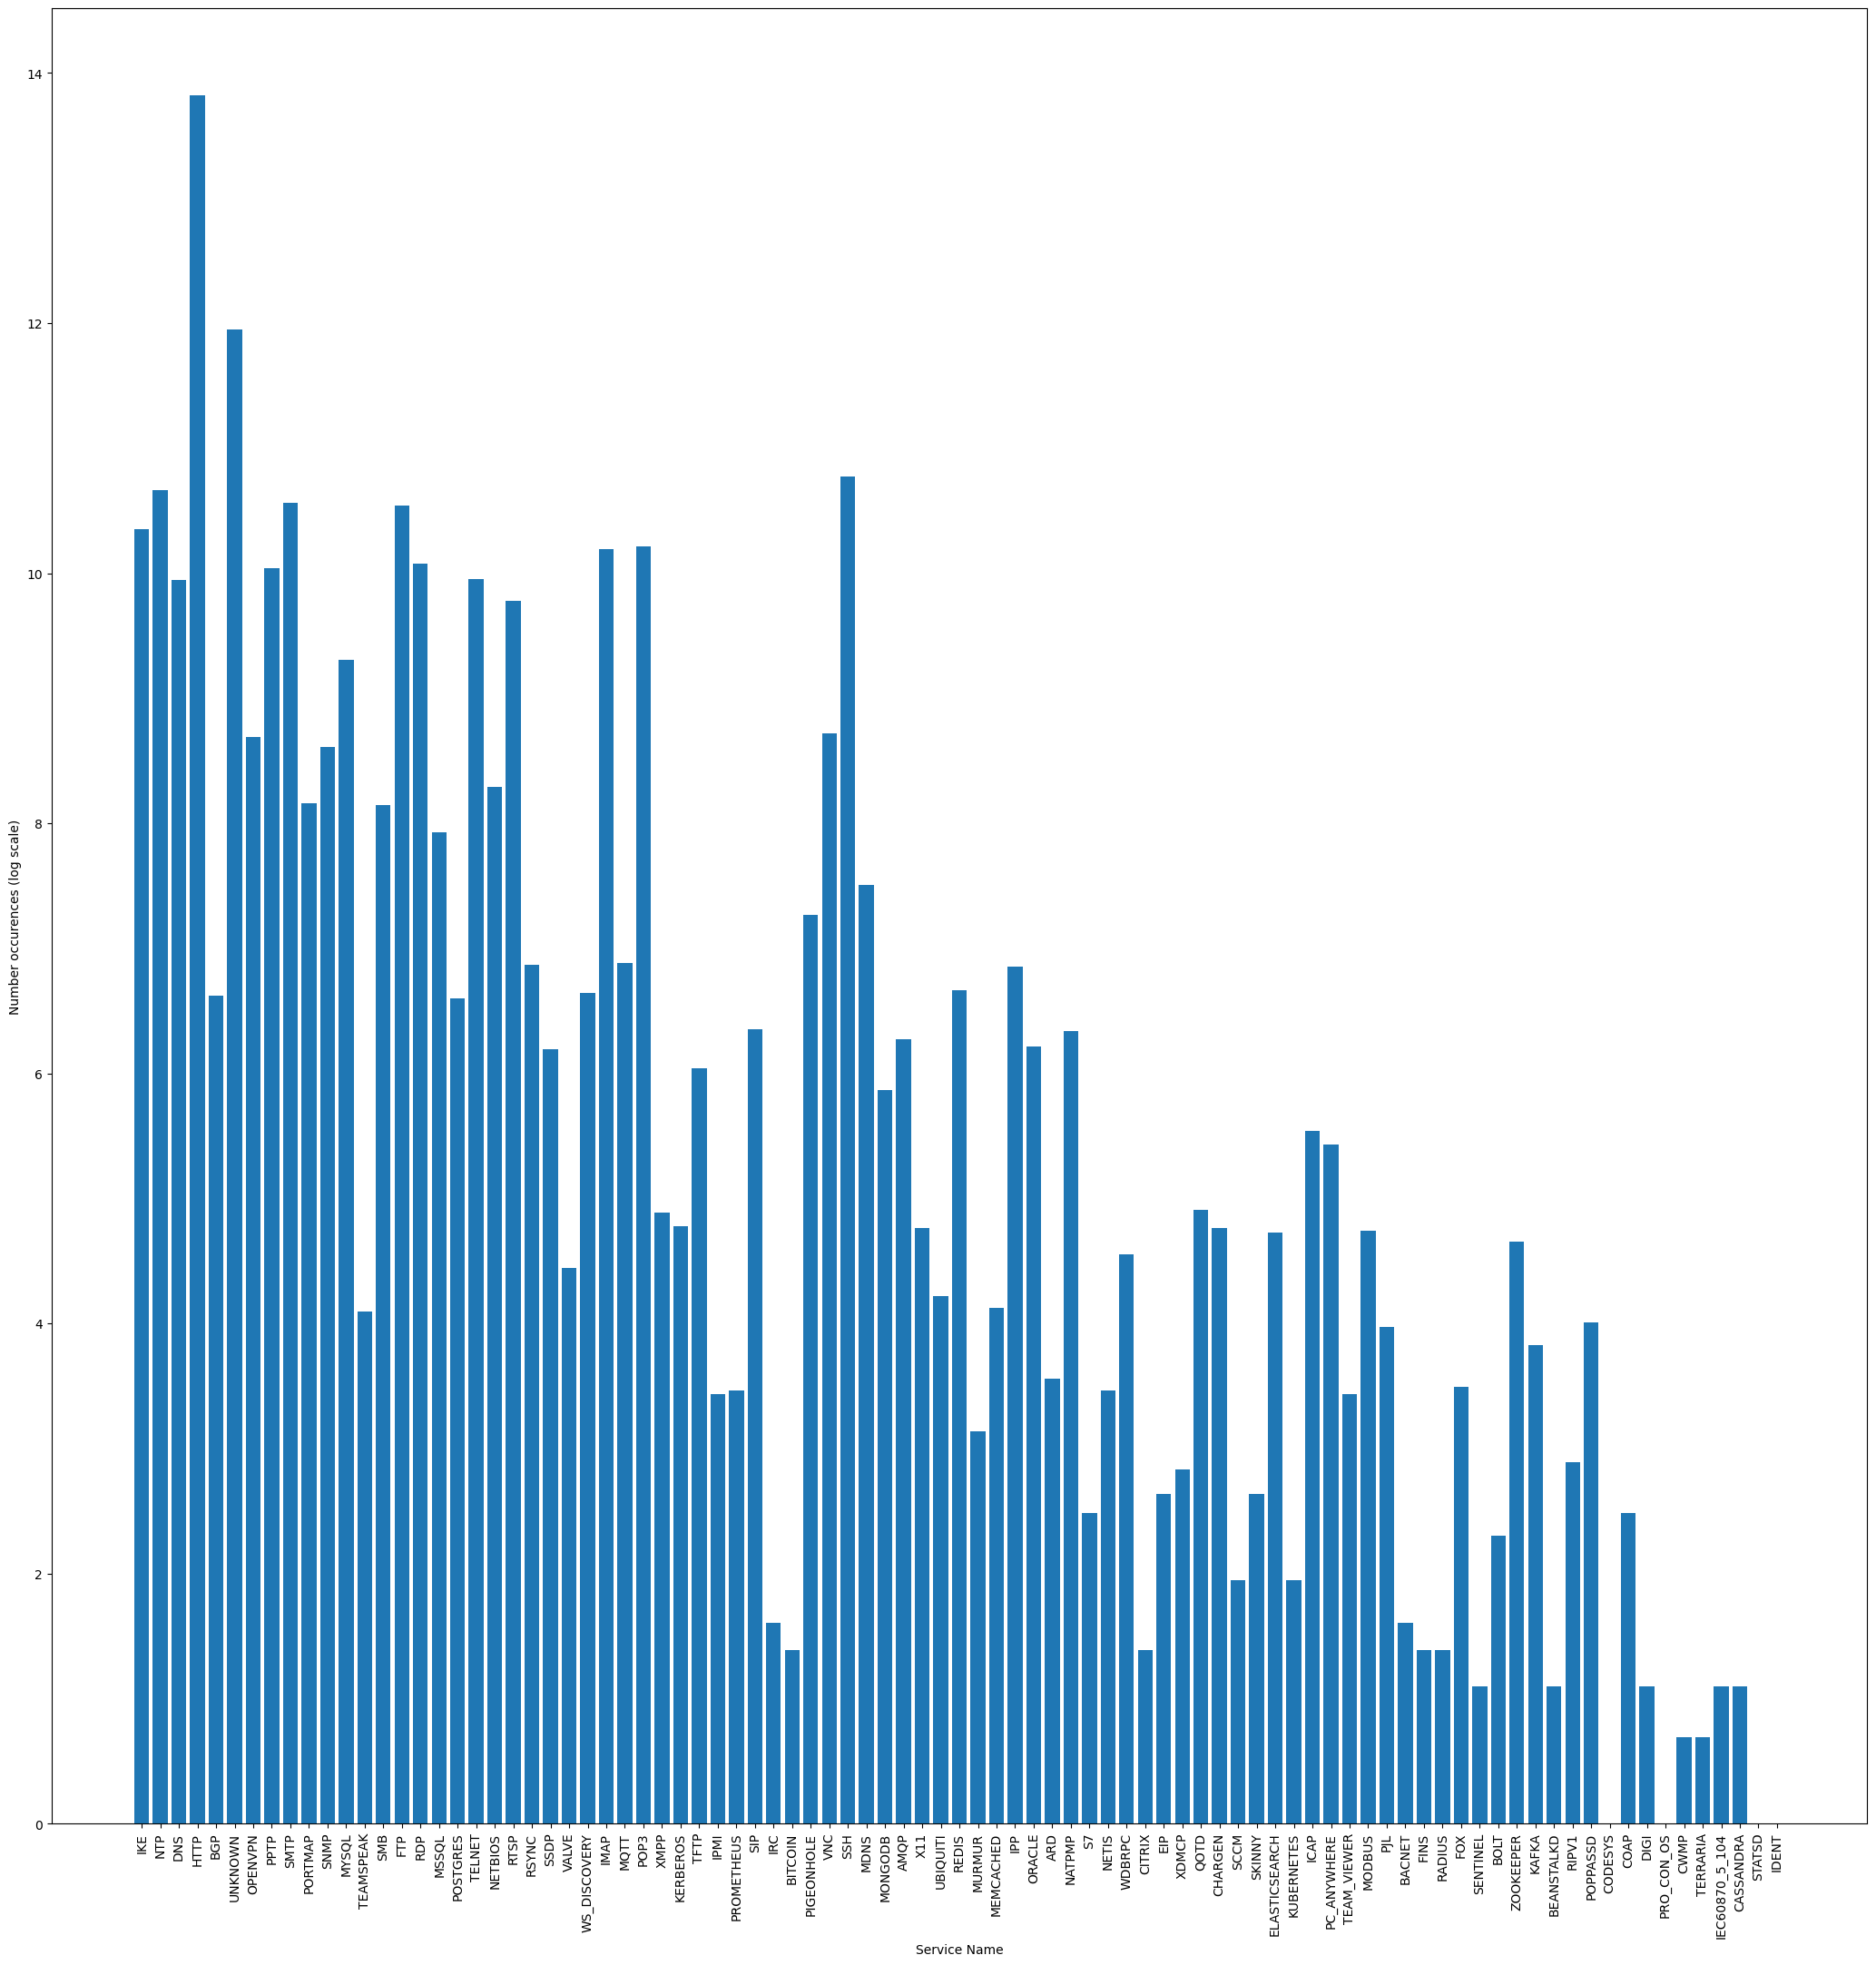

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

data_path = "./data/500kv2.json"

counter = Counter()

df = pd.read_json(data_path, lines=True)
for names in df["service_names_list"]:
    counter.update(names)

top_20 = []
for tup in counter.most_common(20):
    top_20.append(tup[0])

print("Top 20 services by occurence: " + str(top_20))

services = list(counter.keys())
numbers = np.log(np.array(list(counter.values())))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(services, numbers)
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = (20,20)
plt.ylabel("Number occurences (log scale)")
plt.xlabel("Service Name")
plt.show()


# Neural Network Experiments #

## Initial - All 89 Services ##
Let's first perform setup, including defining our cuda device as well as our training methods. You will see three metrics present: loss, accuracy, and complete accuracy. Loss is a representation of how bad of a prediction the model is making; accuracy is how many single service predictions the model gets correct; complete accuracy is how many service sets the model gets completely correct.

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets.dataset import CensysDataset
# import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn

In [29]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [30]:
data_path = "./data/500kv2.json"
dataset = CensysDataset(data_path)

In [31]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=2048, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=2048, shuffle=True)

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.type(torch.LongTensor), y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        # print(X.shape)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [33]:
def test(dataloader, model, loss_fn, threshold, total_loss, accuracy_over_time, complete_correct_over_time):
    size_complete = len(dataloader.dataset)
    size = len(dataloader.dataset) * dataset.get_num_classes()
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, complete_correct = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.type(torch.LongTensor), y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            correct += (pred == y).type(torch.float).sum().item()
            if torch.equal(pred, y):
                complete_correct += 1
    test_loss /= num_batches
    total_loss.append(test_loss)
    correct /= size
    accuracy_over_time.append(100*correct)
    complete_correct /= size_complete
    complete_correct_over_time.append(complete_correct)
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Complete Correct: {complete_correct}, Complete Accuracy: {(100*complete_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Simple Perceptron (100 hidden layers) ###
Now let's define our first model, a 3 layer perceptron with hidden size of 100. Output will be 89 for all the services present.

In [34]:
from models.Perceptron import Perceptron

# model = ResNet1D(1, 2, 3, 1, 1, 8, 59).to(device)
model = Perceptron(100, dataset.get_num_classes()).to(device) 
model.cuda()
print(model)

Perceptron(
  (l1): Linear(in_features=8, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=100, bias=True)
  (l4): Linear(in_features=100, out_features=89, bias=True)
)


Let's define our loss function, Binary Cross Entropy Loss, to work with our multihot labels. Learning rate represents how fast the algorithm learns (too high and we get a lot of nosie in the training loss; too low and our model does not learn fast enough). Threshold is used compared to the output of the model to determine if a service is present or not (i.e. if the model outputs a value "0.42" for the presence of a certain service, if this is above the threshold, the service is predicted to be present, and vice versa.)

In [35]:
loss_fn = nn.BCELoss()
learning_rate = 0.01
threshold = 0.5


# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
epochs = 10
total_loss = []
accuracy_over_time = []
complete_accuracy_over_time = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn, threshold, total_loss, accuracy_over_time, complete_accuracy_over_time)
print("Done!")

Epoch 1
-------------------------------
loss: 0.692065  [    0/400000]
loss: 0.044720  [204800/400000]
Valid Error: 
 Accuracy: 98.6%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 0.041773 

Epoch 2
-------------------------------
loss: 0.041104  [    0/400000]
loss: 0.041143  [204800/400000]
Valid Error: 
 Accuracy: 98.7%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 0.039930 

Epoch 3
-------------------------------
loss: 0.040031  [    0/400000]
loss: 0.037897  [204800/400000]
Valid Error: 
 Accuracy: 98.7%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 0.038676 

Epoch 4
-------------------------------
loss: 0.038825  [    0/400000]
loss: 0.038283  [204800/400000]
Valid Error: 
 Accuracy: 98.8%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 0.037855 

Epoch 5
-------------------------------
loss: 0.037744  [    0/400000]
loss: 0.036730  [204800/400000]
Valid Error: 
 Accuracy: 98.8%, Complete Correct: 0.0, Complete Accuracy: 0.0%, A

These results are certainly intersting. While the model was able to guess the presence of individual services quite well, it did not get a single full 89-service set prediction correct. When we take a look at how a multihot vector is formatted, however, this starts to makes sense. Let's say we have a service set of 10; a label containing two services "A" and "C" will be encoded perhaps as [1 0 2 0 0 0 0 0 0 0]. Given that our service set is 89 services and only a small handful of services is present at any given time, outputting mostly zeros will result in a high accuracy. Much better metrics are precision, recall, and F1-scores, calculated further below.

For the goal of predicting the set of services present, however, the model appears to be a complete dud. Not a single service set was accurately predicted. However, when we graph our loss, we see something interesting:

[0.041772981915546924, 0.03993030204152574, 0.038676422165364634, 0.03785474537586679, 0.037457721041781564, 0.036584580659258126, 0.036291953252286326, 0.03608222001669358, 0.035805689969233105, 0.036112035871768484]


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

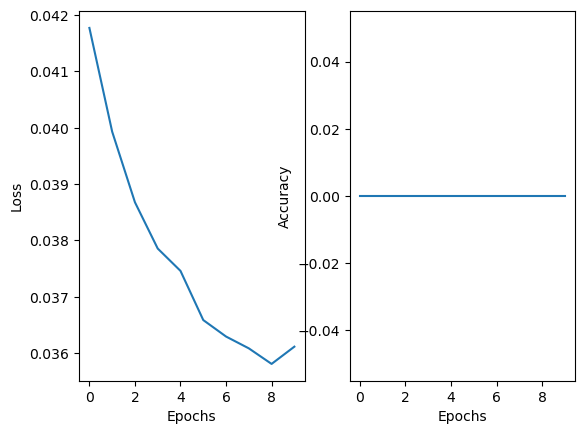

In [39]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
num_epochs = range(10)
print(total_loss)

axis[0].plot(num_epochs, total_loss)
axis[0].set(xlabel="Epochs", ylabel='Loss')

axis[1].plot(num_epochs, complete_accuracy_over_time)
axis[1].set(xlabel="Epochs", ylabel='Accuracy')

Loss decreases over the course of training, so the model is learning something. Let's use scikits classification report to generate the precision (True Positives / (True Positives + False Positives)), recall (True Positives / (True Positives + False Negatives)), and F1-score (2 * (Precision * Recall) / (Precision + Recall)) for each service. While most of the services output zero for reasons I am not quite certain of, some have actual values. We pull these out into a table (NOTE: this will take a bit to run).

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_preds = []
y_acts = []

for i in range(500000):
    X, y = dataset[i]
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    pred = pred.to("cpu").detach().numpy()
    y = y.to("cpu").detach().numpy()

    y_preds.append(pred)
    y_acts.append(y)

print(classification_report(y_acts, y_preds, output_dict=False, target_names=dataset.service_le.classes_))

### Classification Results ###
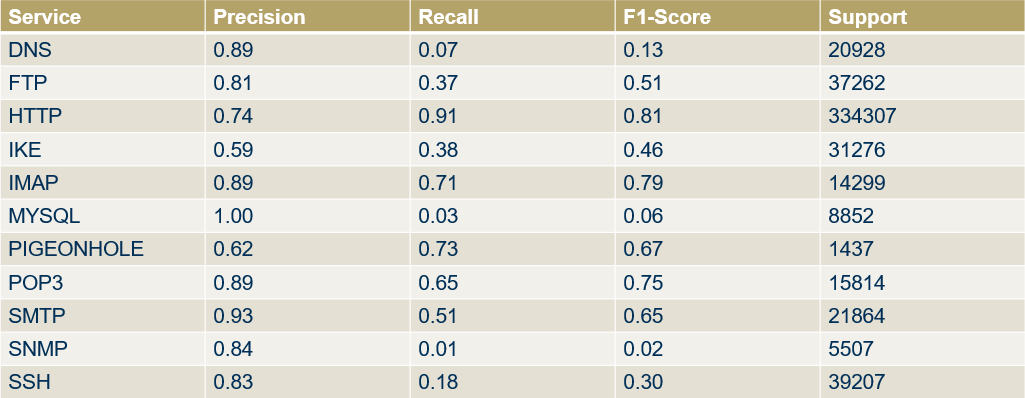

We see that the model was incredibly good at predicting HTTP; this can be attributed to the fact that most systems run HTTP regardless of external factors. More interesting is services such as IMAP, PIGEONHOLE, and POP3. Let's use captum to determine feature importance for IMAP, a service that allows acces to email from any device:

In [ ]:
# Feel free to substitute in which service you would like to see the importance scores of! For the report, we look at IMAP
target_service = "IMAP"

torch.Size([1, 8])
torch.Size([1, 89])
[25]
tensor([[-1.9551e-02,  4.4315e-02, -5.5360e-02,  5.6010e-04, -2.5723e-02,
          5.5388e-02, -3.5271e-02, -1.4868e-10]], device='cuda:0',
       dtype=torch.float64)


Text(0.5, 1.0, 'Importance Scores for Parameters')

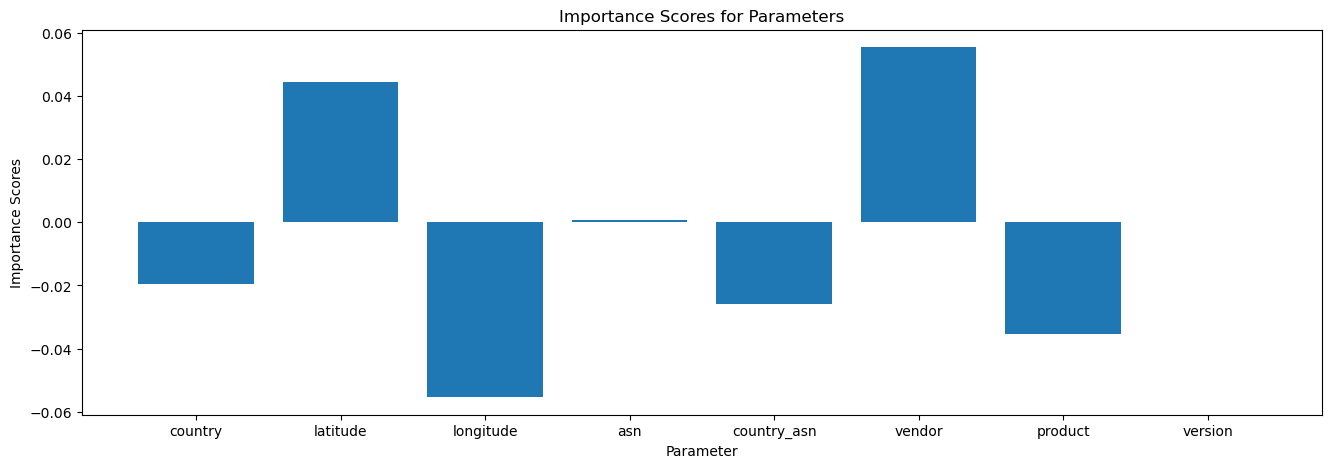

In [57]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

sample_features = dataset[0][0]
sample_labels = dataset[0][1].reshape((1, 89)).to(device)

sample_features = sample_features.reshape((1,8)).to(device)
# print(sample_features.shape)
# print(sample_labels.shape)


target_int = dataset.service_le.transform([target_service])[0]

#Calculate the importance scores for the model
model.eval()
integrated_gradients = IntegratedGradients(model)
ig = integrated_gradients.attribute(sample_features, target=target_int)
# print(ig)

#plot the importance scores
plt.figure(figsize=[16,5])

fields = ['country', 'latitude', 'longitude', 'asn', 'country_asn', 'vendor', 'product', 'version']
igs = ig.flatten().tolist()


plt.bar(range(len(fields)), igs)
plt.xticks(range(len(fields)), fields)

plt.xlabel('Parameter')
plt.ylabel('Importance Scores')

plt.title('Importance Scores for Parameters')

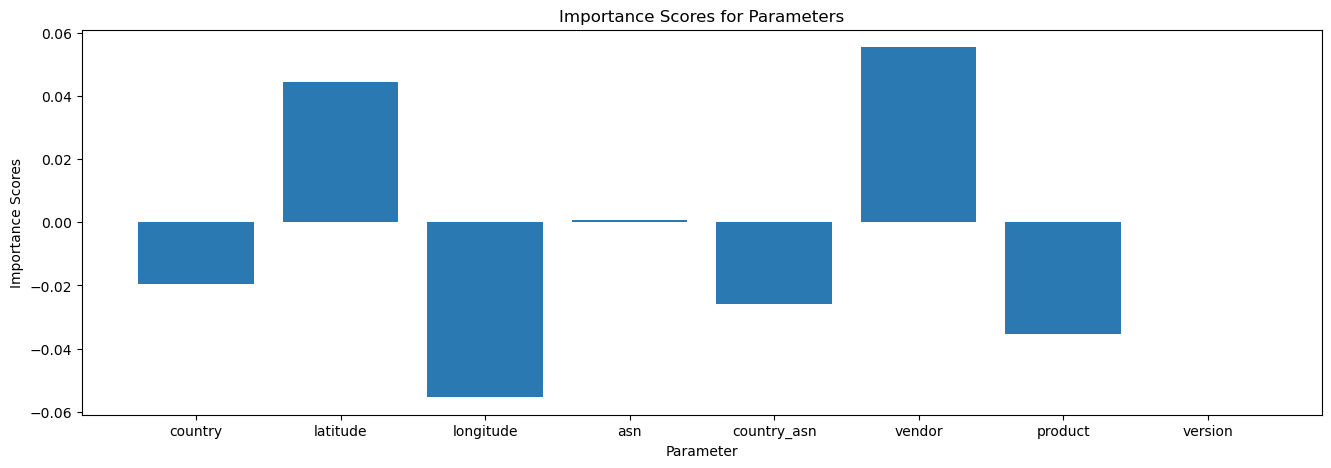<br>
We see that the model placed latitude and vendor at greater importance than other features. Vendor makes a great deal of sense: IMAP is provided by Microsoft, so if the software is vended by Microsoft, it's likely that it will contain IMAP. Latitude is the more interesting inclusion; perhaps the heavy presence of internet infrastructure in the Northern Hemisphere (particularly Europe and North America) can explain this?

## Predicting top 20 services - Unnormalized Dataset ##
Let's try restricting the services we're trying to predict to the top 20 services. Let's also use an unnormalized dataset, as the algorithm should be able to account for the unnormalized values (a thought that did not occur to me until after performing initial experiments with normalized data).

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from datasets.dataset_no_norm import CensysDataset
# import torch.nn.functional as F
from torch.utils.data import random_split
import torch.nn as nn

In [5]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [6]:
data_path = "./data/500kv2.json"
dataset = CensysDataset(data_path, top_20)

In [7]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=2048, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=2048, shuffle=True)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.type(torch.LongTensor), y.type(torch.LongTensor)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        # print(X.shape)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn, threshold, total_loss, accuracy_over_time, complete_correct_over_time):
    size_complete = len(dataloader.dataset)
    size = len(dataloader.dataset) * dataset.get_num_classes()
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, complete_correct = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.type(torch.LongTensor), y.type(torch.LongTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred[pred >= threshold] = 1
            pred[pred < threshold] = 0
            correct += (pred == y).type(torch.float).sum().item()
            if torch.equal(pred, y):
                complete_correct += 1
    test_loss /= num_batches
    total_loss.append(test_loss)
    correct /= size
    accuracy_over_time.append(100*correct)
    complete_correct /= size_complete
    complete_correct_over_time.append(complete_correct)
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Complete Correct: {complete_correct}, Complete Accuracy: {(100*complete_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



### Simple Perceptron, 100 layers ###

In [13]:
from models.Perceptron import Perceptron

# model = ResNet1D(1, 2, 3, 1, 1, 8, 59).to(device)
model = Perceptron(100, dataset.get_num_classes()).to(device) 
model.cuda()
print(model)

Perceptron(
  (l1): Linear(in_features=8, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=100, bias=True)
  (l4): Linear(in_features=100, out_features=20, bias=True)
)


In [14]:
loss_fn = nn.BCELoss()
learning_rate = 0.001
threshold = 0.5


# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
epochs = 10
total_loss = []
accuracy_over_time = []
complete_accuracy_over_time = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn, threshold, total_loss, accuracy_over_time, complete_accuracy_over_time)
print("Done!")

Epoch 1
-------------------------------
loss: 27.565912  [    0/400000]
loss: 4.814185  [204800/400000]
Valid Error: 
 Accuracy: 94.1%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 5.447097 

Epoch 2
-------------------------------
loss: 5.467906  [    0/400000]
loss: 5.630548  [204800/400000]
Valid Error: 
 Accuracy: 94.1%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 5.493380 

Epoch 3
-------------------------------
loss: 5.451879  [    0/400000]
loss: 5.734316  [204800/400000]
Valid Error: 
 Accuracy: 94.1%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 5.879016 

Epoch 4
-------------------------------
loss: 5.632005  [    0/400000]
loss: 5.957638  [204800/400000]
Valid Error: 
 Accuracy: 94.1%, Complete Correct: 0.0, Complete Accuracy: 0.0%, Avg loss: 5.893137 

Epoch 5
-------------------------------
loss: 5.847790  [    0/400000]
loss: 5.983050  [204800/400000]
Valid Error: 
 Accuracy: 94.1%, Complete Correct: 0.0, Complete Accuracy: 0.0%, 

[5.4470972820204135, 5.493380079464036, 5.879016126905169, 5.893137454986572, 5.791938402214829, 5.818735979041275, 5.750266084865648, 5.693525800899583, 5.6349303673724735, 10.261089305488431]


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

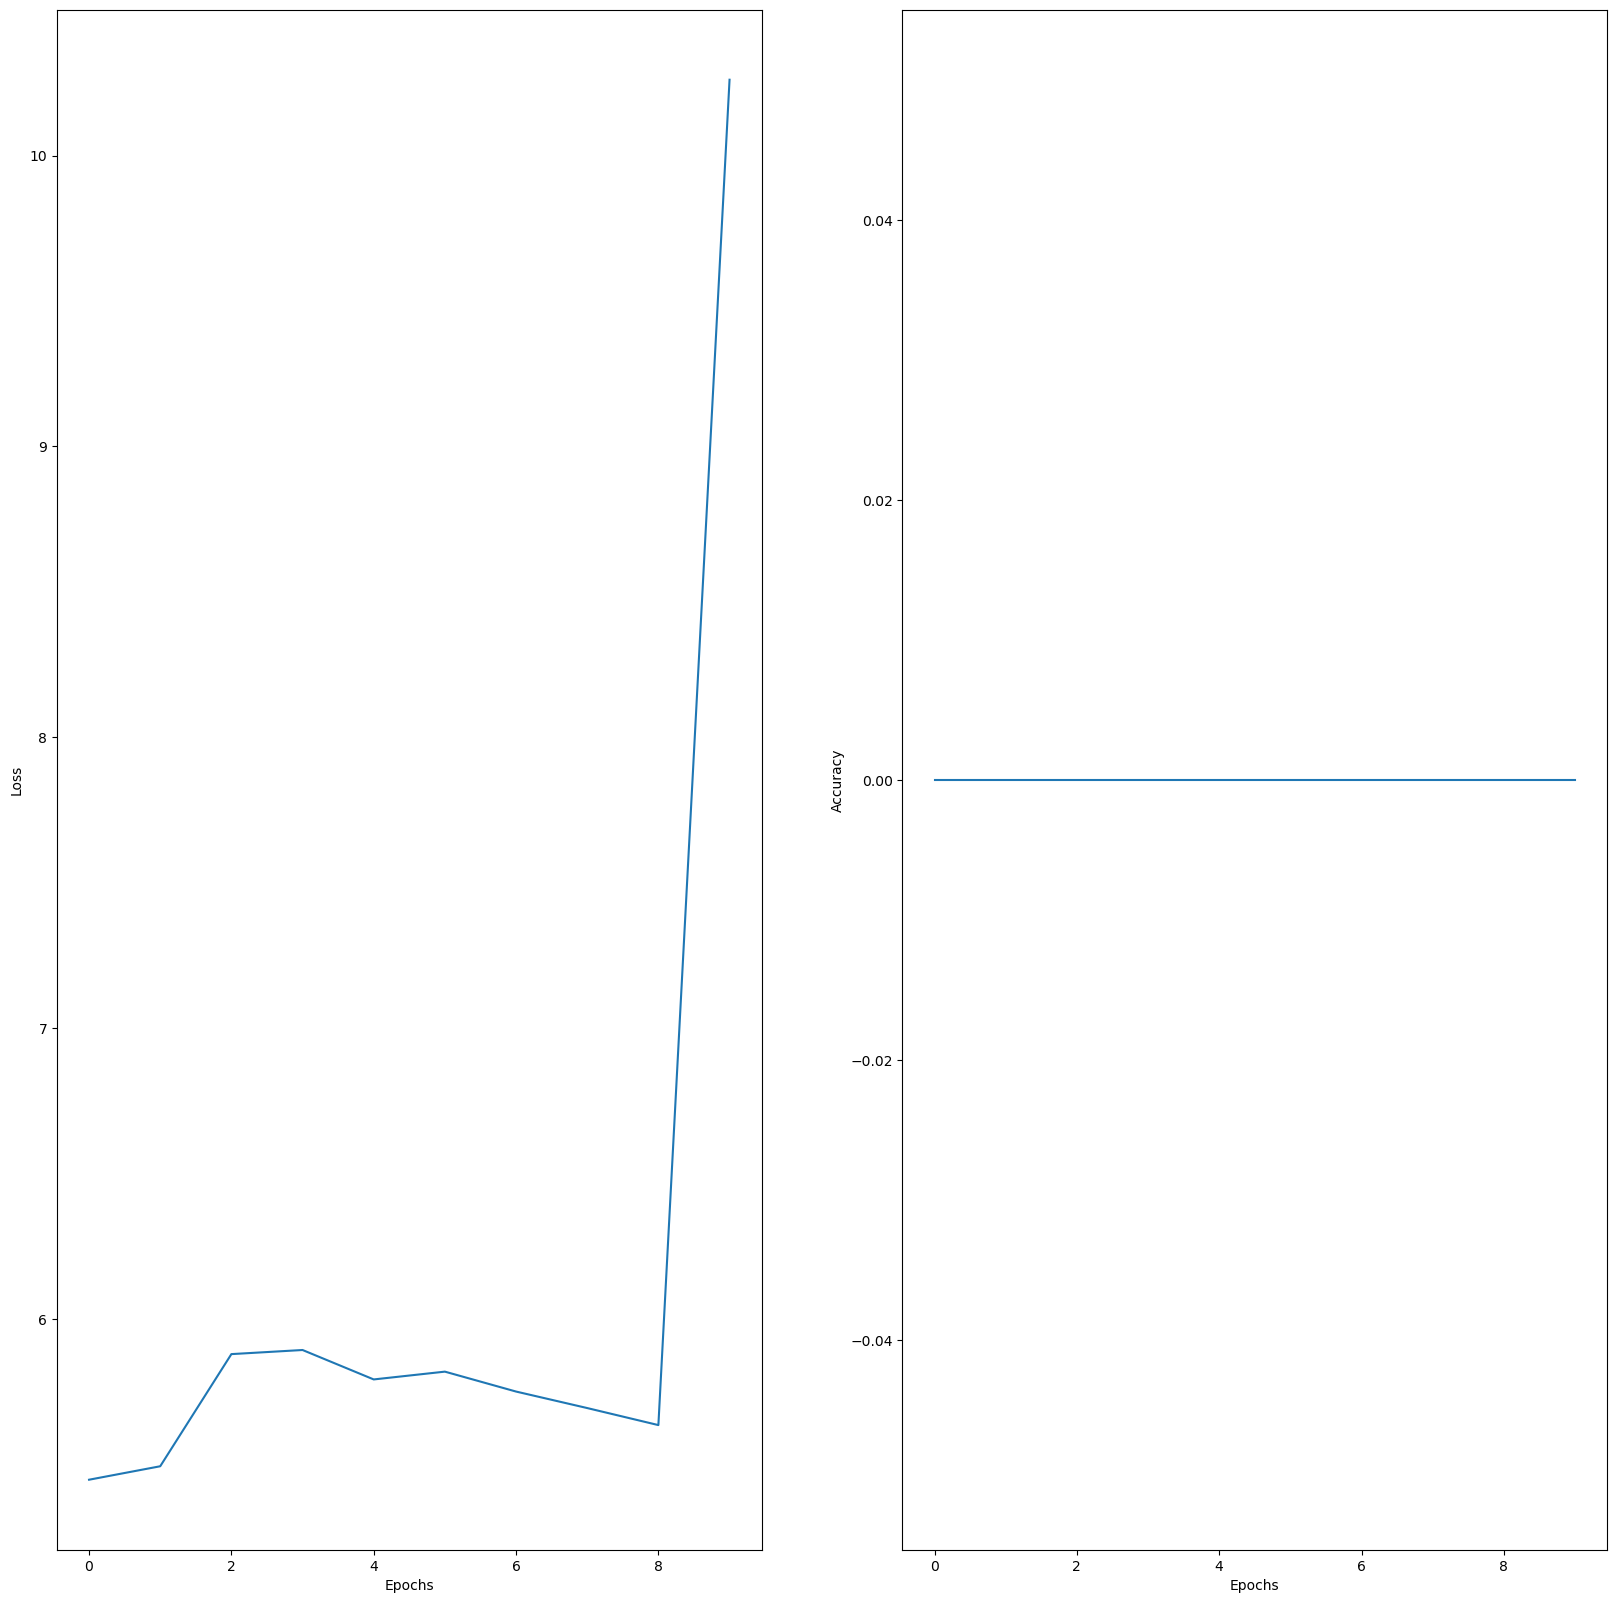

In [16]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)
num_epochs = range(10)
print(total_loss)

axis[0].plot(num_epochs, total_loss)
axis[0].set(xlabel="Epochs", ylabel='Loss')

axis[1].plot(num_epochs, complete_accuracy_over_time)
axis[1].set(xlabel="Epochs", ylabel='Accuracy')

It appears that the model was unable to learn anything worthwhile from the data (as evidenced by the overall increase in loss). Two potential reasons for this: first, many entries might have labels without a single service in the top 20; second, the presence of some of the top 20 might be completely unrelated to the input features. Let's run the classification report, though the results will be poor considering that the model did not seem to learn.

In [33]:
from sklearn.metrics import classification_report
import numpy as np

y_preds = []
y_acts = []

for i in range(500000):
    X, y = dataset[i]
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0

    pred = pred.to("cpu").detach().numpy()
    y = y.to("cpu").detach().numpy()

    y_preds.append(pred)
    y_acts.append(y)

print(classification_report(y_acts, y_preds, output_dict=False, target_names=dataset.service_le.classes_))

c:\Users\Thats\miniconda3\envs\ids\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         DNS       0.00      0.00      0.00     20928
         FTP       0.00      0.00      0.00     37262
        HTTP       0.67      1.00      0.80    334307
         IKE       0.06      1.00      0.12     31276
        IMAP       0.00      0.00      0.00     14299
       MYSQL       0.00      0.00      0.00      8852
     NETBIOS       0.00      0.00      0.00      3482
         NTP       0.00      0.00      0.00     42703
     OPENVPN       0.00      0.00      0.00      5135
        POP3       0.00      0.00      0.00     15814
     PORTMAP       0.00      0.00      0.00      3503
        PPTP       0.00      0.00      0.00     22938
         RDP       0.00      0.00      0.00     12491
        RTSP       0.00      0.00      0.00     17606
        SMTP       0.00      0.00      0.00     21864
        SNMP       0.00      0.00      0.00      5507
         SSH       0.00      0.00      0.00     39207
      TELNET       0.00    

c:\Users\Thats\miniconda3\envs\ids\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HTTP appears to be the only one that classification was able to output scores for due to zero division issues, which makes sense as we were expecting a poor output. Let's see the captum importance, though again, it most likely will not mean much due to the performance of the model.

In [29]:
# Feel free to substitute in which service you would like to see the importance scores of! For the report, we look at IMAP
target_service = "IMAP"

16
tensor([[-1.0885e-03,  1.7815e-03,  1.4959e-03, -4.9735e-01,  6.2949e-04,
          1.9016e-03,  2.9508e-03, -1.0026e-05]], device='cuda:0',
       dtype=torch.float64)


Text(0.5, 1.0, 'Importance Scores for Parameters')

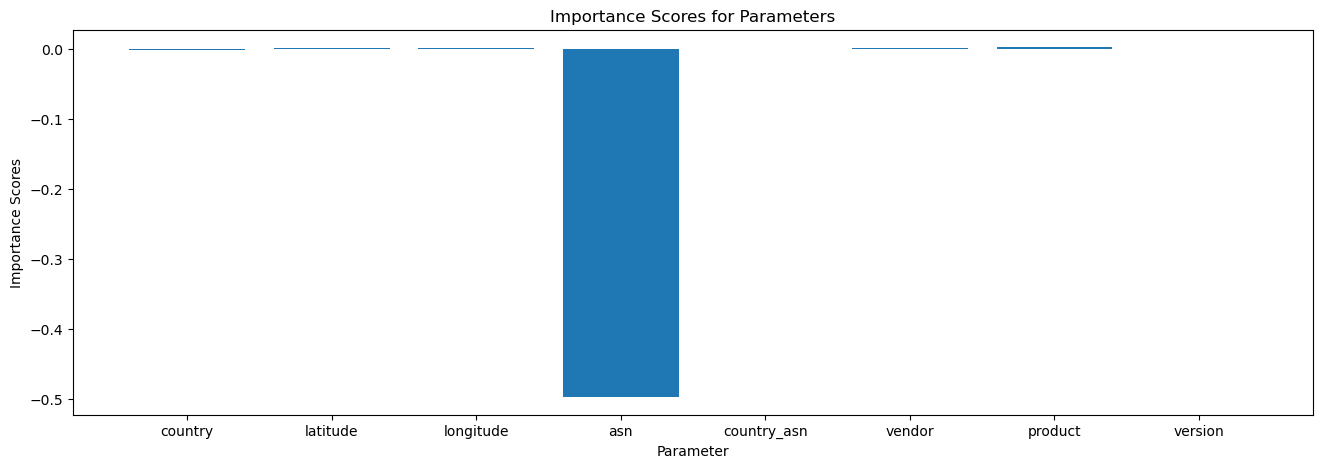

In [30]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

sample_features = dataset[0][0]
sample_labels = dataset[0][1].reshape((1, 20)).to(device)

sample_features = sample_features.reshape((1,8)).to(device)
# print(sample_features.shape)
# print(sample_labels.shape)

target_int = int(dataset.service_le.transform([target_service])[0])
print(target_int)

#Calculate the importance scores for the model
model.eval()
integrated_gradients = IntegratedGradients(model)
ig = integrated_gradients.attribute(sample_features, target=target_int)
print(ig)

#plot the importance scores
plt.figure(figsize=[16,5])

fields = ['country', 'latitude', 'longitude', 'asn', 'country_asn', 'vendor', 'product', 'version']
igs = ig.flatten().tolist()


plt.bar(range(len(fields)), igs)
plt.xticks(range(len(fields)), fields)

plt.xlabel('Parameter')
plt.ylabel('Importance Scores')

plt.title('Importance Scores for Parameters')

The skew against ASN is interesting, but not meaningful. Overall, it seems like restricting prediction to the top 20 services did not result in a better output.

## Discussion ##
There are several issues that might have affected the performance of the several models. First, the input features might not actually have any relation to the services a host is running. While we saw the model learn some relation when predicting the full set of 89 services and captum provided some information about feature importance, these might not have been indicative of actual trends. Second, the data preprocessing might have resulted in too few features to feed into the model or might have removed too much information from included fields. Including more text fields, such as the "Description" field from Censys, might lend more useful information; however, this would require delving into Natural Language Processing and generate multiple-dimension embeddings that would skew importance towards the encoded language. Finally, the choice to approach this problem as a multilabel classification might not have been the best way to determine relations between input features and the service set; perhaps breaking down the service set and predicting the presence of one service at a time would yield more information.

## Future Work ##
- Predict on a service-by-service basis to gain more specific information
- Train on a larger corpus
- Try deepening models or using more complex models
    - Get an attention-based perceptron working

## Conclusion ##
The initial purpose of the project was to attempt to predict the services a system hosted using service-unrelated information. In my experiments on my data subset - composing of 500k entries drawn from censys - this took the form of predicting which services out of a set of 89 services are present per system. The classifier built for this was unsuccessful in this regard, being unable to get a single prediction completely correct; restricting this service set to predicting the top 20 services similarly failed. However, the loss curve for the 89-service model indicated that something was being learned and predictions were improving. Looking into further metrics such as recall, precision, and F1-score, it appeared that certain services were being predicted at moderately succesful rates; analyzing captum visualizations for the importance of features for these services yielded interesting trends. While the original project aims were a dud, the findings regarding specific services such as IMAP are interesting enough to encourage further, more specific study. 